In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import vlass_search
import csv
import re
import os
from urllib.error import HTTPError
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u


C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


File downloaded to: VLASS_dyn_summary.php


In [14]:
source_names = ["ZTF19abucwzt", "ZTF18acpdvos", "ZTF19adaxzax", "ZTF19abzrhgq", "ZTF17aaazdba"]
source_cs = [["07:07:59.25", "+31:39:55.3"],["10:06:50.87","+01:41:34.0"],
              ["00:10:10.69","-06:00:03.5"], ["04:46:37.88","-10:13:34.8"],
              ["08:13:16.95","+22:38:53.9"]]

source_dict = {"Names": source_names, "Coords": source_cs}


for n in range(len(source_dict["Names"])):
    skyguy = SkyCoord(ra = source_dict["Coords"][n][0], 
                      dec = source_dict["Coords"][n][1],
                      unit=(u.hourangle, u.deg))
    name = source_names[n]
    vlass_search.run_search(name, skyguy)


Running for ZTF19abucwzt
Coordinates <SkyCoord (ICRS): (ra, dec) in deg
    (106.996875, 31.66536111)>
Date: None

Looking for tile observation for T18t10
https://archive-new.nrao.edu/vlass/quicklook/VLASS1.2v2/T18t10/
Tile Found:
T18t10 VLASS1.2v2
https://archive-new.nrao.edu/vlass/quicklook/VLASS1.2v2/T18t10/VLASS1.2.ql.T18t10.J070559+313000.10.2048.v1/VLASS1.2.ql.T18t10.J070559+313000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
PNG file images\ZTF19abucwzt_VLASS1.2v2.png already exists. Skipping download.
Run search completed in 0.25 seconds.

Looking for tile observation for T18t10
https://archive-new.nrao.edu/vlass/quicklook/VLASS2.2/T18t10/
Tile Found:
T18t10 VLASS2.2
https://archive-new.nrao.edu/vlass/quicklook/VLASS2.2/T18t10/VLASS2.2.ql.T18t10.J070559+313000.10.2048.v1/VLASS2.2.ql.T18t10.J070559+313000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
PNG file images\ZTF19abucwzt_VLASS2.2.png already exists. Skipping download.
Run search completed in 0.26 seconds.

Looking for t

In [2]:
""" Writing the Ia_supernovae dataframe"""

df = pd.read_csv("ztf_transients.csv")

df = pd.DataFrame(df)


ia_df = df[df['type'].str.contains('SN Ia', case=False, na=False)]

ia_df.reset_index(drop=True, inplace=True)

ia_df.to_csv('ia_supernovae.csv', index= False)


C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_53844\125738038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ia_redshifts['redshift'] = pd.to_numeric(ia_redshifts['redshift'], errors='coerce')


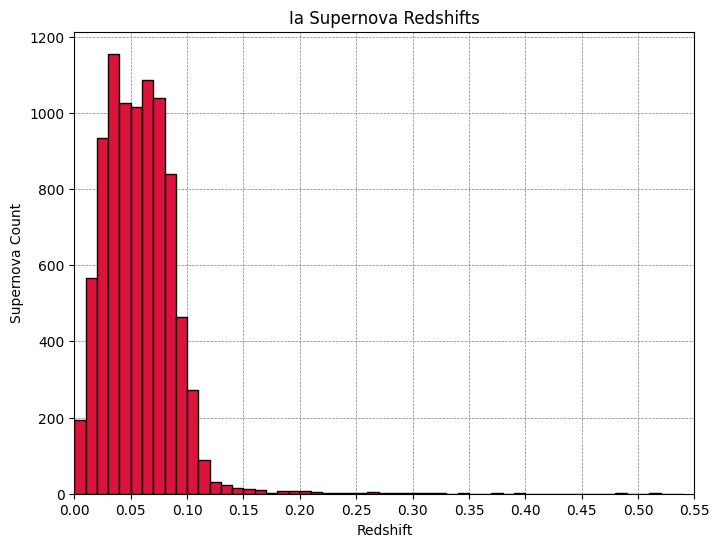

In [3]:
ia_redshifts = df[df['redshift'].notna() & (df['redshift'] != '')]

ia_redshifts['redshift'] = pd.to_numeric(ia_redshifts['redshift'], errors='coerce')

bin_edges = np.arange(0, ia_redshifts['redshift'].max() + 0.025, 0.01)

# Plot the histogram with custom bin edges
plt.figure(figsize=(8, 6))
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder = 1)
plt.hist(ia_redshifts['redshift'], bins=bin_edges, color='crimson', edgecolor='black', zorder = 2)
plt.title('Ia Supernova Redshifts')
plt.xlabel('Redshift')
plt.ylabel('Supernova Count')
plt.xlim(bin_edges[0], bin_edges[-1])

# Set x-ticks at intervals of 0.05 for better readability
xticks = np.arange(0, ia_redshifts['redshift'].max() + 0.05, 0.05)
plt.xticks(xticks)


# Show the plot
plt.show()



In [4]:
def get_png_filenames(transient_name, image_folder='images'):
    """
    Given a transient name in string form, returns all of the png images of the form "{transient_name}_VLASS"
    in a list in the image folder
    """
    
    # Initialize an empty list to store matching filenames
    matching_files = []

    # Iterate over all files in the image folder
    for filename in os.listdir(image_folder):
        # Check if the filename starts with the transient name followed by '_VLASS'
        if filename.startswith(f"{transient_name}_VLASS"):
            # Construct the full path including the 'images/' folder
            full_path = os.path.join(image_folder, filename)
            # Add the full path to the list
            matching_files.append(full_path)

    return matching_files

def extract_flux_values(text):
    # Define regex patterns for peak flux and RMS flux
    peak_flux_pattern = r"Peak Flux (\d+\.\d+)"
    rms_flux_pattern = r"RMS Flux (\d+\.\d+)"

    # Search for the patterns in the text
    peak_flux_match = re.search(peak_flux_pattern, text)
    rms_flux_match = re.search(rms_flux_pattern, text)

    # Extract the values if the patterns are found
    if peak_flux_match and rms_flux_match:
        peak_flux = float(peak_flux_match.group(1))
        rms_flux = float(rms_flux_match.group(1))
        return peak_flux, rms_flux
    else:
        return None, None
    
from PIL import Image
import pytesseract

# Path to the Tesseract-OCR executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def read_flux_from_image(image_path):
    # Open the image file
    img = Image.open(image_path)
    
    # Use pytesseract to do OCR on the image
    text = pytesseract.image_to_string(img)
    
    peak_flux, rms_flux = extract_flux_values(text)
    
    return peak_flux, rms_flux

def extract_epoch(image_name):
    """
    Extract the epoch from the image name.
    
    :param image_name: The name of the image file.
    :return: The extracted epoch or None if not found.
    """
    # Split the string by underscores and take the second part
    try:
        epoch_with_ext = image_name.split('_')[1]
        epoch = epoch_with_ext.split('.png')[0]
        return epoch
    except IndexError:
        return None


In [5]:
def generate_row(name, c, image_dir='images'):
    """
    Generates a row of VLASS PNGs at a given sky coordinate

    Parameters
    -----------
    name: name of the source
    c: coordinates as SkyCoord object
    -----------
    """
    try:
        images, epochs, dates = vlass_search.run_search(name, c)
    except HTTPError as e:
        if e.code == 404:
            print(f"Error 404: URL not found for {name}")
            images, epochs, dates = ['images/unimaged.png'] * 3, ['NA'] * 3, ['Invalid date'] * 3
        else:
            raise e
    
    return {'name': name, 'images': images, 'epochs': epochs, 'vla_dates': dates}

In [6]:
def get_multiple_rows(start, end, dataframe):

    image_paths = []

    for i in range(start - 1, end):
        name = dataframe['ZTFID'][i]
        ra = dataframe['RA'][i]
        dec = dataframe['Dec'][i]
        start_date = dataframe['StartJD'][i]
        skyguy = SkyCoord(ra = ra, dec = dec, unit = (u.hourangle, u.deg))
        # add date to dictionary items
        object_dict = generate_row(name, skyguy)
        object_dict['start_date'] = start_date
        image_paths.append(object_dict)

    for obj in image_paths:
        deltas = []
        print(obj)

        for x in obj['vla_dates']:
            # Convert VLA dates to Julian dates
            if x != 'Invalid date':
                x = Time(x, format = 'iso')
                vla_jd_date = x.jd
            else:
                vla_jd_date = 'NA'
            deltas.append(vla_jd_date)
            print(f"VLA JD Date: {vla_jd_date} (type: {type(vla_jd_date)})")

        print(f"ZTF JD Date: {obj['start_date']} (type: {type(obj['start_date'])})")

        # Ensure the type of ZTF date is float
        start_date = float(obj['start_date'])

        for i in range(len(deltas)):
            if deltas[i] != 'NA':
                deltas[i] = round(deltas[i] - start_date, 2)

        obj['delta_ts'] = deltas
        print(f"Deltas: {deltas}")
        
    return image_paths


In [44]:
ia_dataframe = pd.read_csv("ia_supernovae_with_start_jd.csv")
ia_dataframe.drop('Unnamed: 0', axis=1, inplace=True)

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,StartJD
0,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053,2.459851e+06
1,ZTF17aacldgo,SN2022zxv,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.07200,-50.332472,0.183,2.459894e+06
2,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.06200,34.174702,0.106,2.458864e+06
3,ZTF18aaaonon,SN2022jjs,10:19:05.51,+14:24:16.6,1703.77,g,18.5663,-19.08,>18.631,3.691,>14.94,SN Ia,0.07141,52.363911,0.150,2.459700e+06
4,ZTF18aaaqexr,SN2020chl,11:43:06.37,+15:34:01.7,891.92,g,18.4475,-19.10,17.228,5.46,11.768,SN Ia,0.07020,70.370720,0.101,2.458887e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6399,ZTF24aahkesn,SN2024eae,15:37:54.34,-03:51:21.8,2391.94,r,18.4142,-19.42,>11.401,>1.98,9.421,SN Ia,0.06800,39.285574,0.570,2.460384e+06
6400,ZTF24aahlvgk,SN2024ewu,07:01:04.26,+24:23:22.0,2392.70,g,18.4201,-19.49,>17.897,>2.01,15.887,SN Ia-pec,0.08000,12.847346,0.162,2.460391e+06
6401,ZTF24aahmgvr,SN2024exp,09:44:01.40,-14:54:05.2,2403.75,r,17.1213,-18.65,25.135,8.305,16.83,SN Ia,0.03000,28.092871,0.249,2.460391e+06
6402,ZTF24aahmqzq,SN2024ead,15:47:50.73,-08:25:59.0,2390.98,g,18.2567,-19.26,>10.095,>0.09,>10.005,SN Ia,0.05931,34.424666,0.381,2.460384e+06


### New Attempt

Creating the Dataframe with the New Delta T's


In [118]:
all_transient_df = pd.DataFrame(pd.read_csv("interesting_transients.csv"))

ia_supernovae_df = pd.DataFrame(pd.read_csv("ia_supernovae_with_start_jd.csv"))

ia_sn_df = pd.merge(all_transient_df, ia_supernovae_df[['ZTFID', 'StartJD', 'peakt', 'redshift']],
                     left_on = 'Transient Name', right_on = 'ZTFID', how = 'inner')

ia_sn_df.reset_index(drop = True, inplace = True)

ia_sn_df['peaktJD'] = ia_sn_df['peakt'] + 2458000

ia_sn_df = ia_sn_df.rename(columns={'Delta T': 'old_dt'}).drop(['peakt', 'ZTFID'], axis = 1)

ia_sn_df['dt'] = ia_sn_df['old_dt'] - ia_sn_df['StartJD'] + ia_sn_df['peaktJD']

ia_sn_df['dt'] = ia_sn_df['dt'].round(2)

ia_sn_df = ia_sn_df.drop(['old_dt', 'StartJD', 'peaktJD'], axis = 1)

ia_sn_df.to_csv("final_ia_transients.csv", index = False)

### Creating dt histogram

In [8]:
ia_sn_df = pd.DataFrame(pd.read_csv("final_ia_transients.csv"))

ia_after_df = ia_sn_df[ia_sn_df['dt'] >= 0].reset_index(drop = True)


### dt Histogram all dts

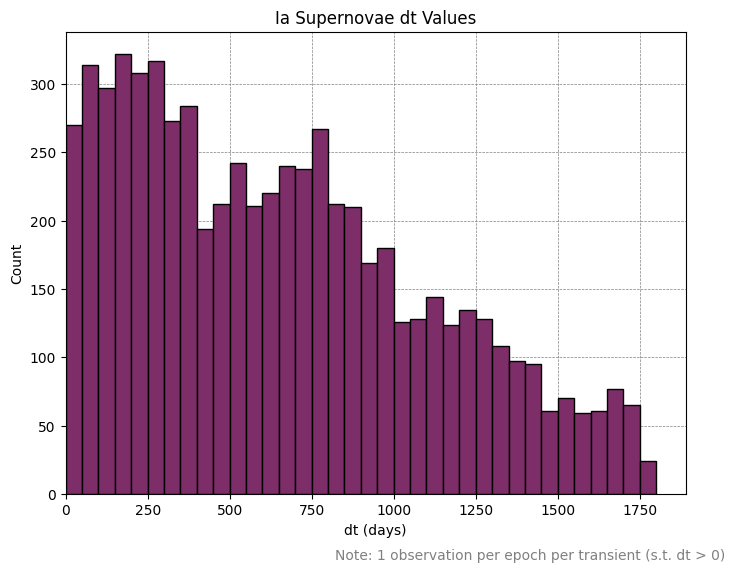

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges with an even width of 50, starting from 0
bin_width = 50
bin_edges = np.arange(0, ia_after_df['dt'].max() + bin_width, bin_width)

# Plot the histogram with custom bin edges
plt.figure(figsize=(8, 6))

# Add grid with dashed lines
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=1)

# Create the histogram
plt.hist(ia_after_df['dt'], bins=bin_edges, color='#7D2E68', edgecolor='black', zorder=2)

# Set the x-axis limits to start at 0 to remove white space
plt.xlim(left=0)

# Add labels and title
plt.title('Ia Supernovae dt Values')
plt.xlabel('dt (days)')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per epoch per transient (s.t. dt > 0)', 
            fontsize=10, color='gray', ha='right')


# Show the plot
plt.show()


### dt Histogram t 0-200 days

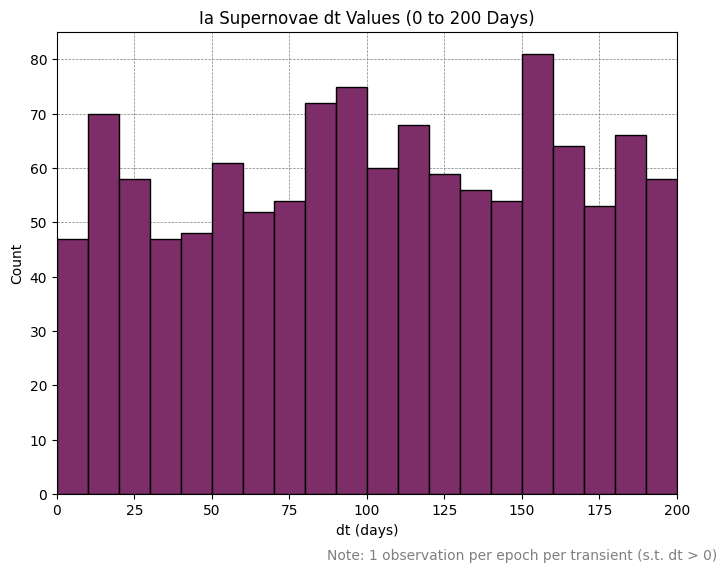

In [56]:
# Filter the data to include only dt values from 0 to 200 days
ia_after_df_zoom = ia_after_df[ia_after_df['dt'] <= 200]

# Define the bin edges with an even width of 10, focusing on the range from 0 to 200
bin_width = 10
bin_edges = np.arange(0, 200 + bin_width, bin_width)

# Plot the histogram for dt values from 0 to 200 days
plt.figure(figsize=(8, 6))

# Add grid with dashed lines
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=1)

# Create the histogram
plt.hist(ia_after_df_zoom['dt'], bins=bin_edges, color='#7D2E68', edgecolor='black', zorder=2)

# Set the x-axis limits to focus on the range from 0 to 200 days
plt.xlim(0, 200)

# Add labels and title
plt.title('Ia Supernovae dt Values (0 to 200 Days)')
plt.xlabel('dt (days)')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per epoch per transient (s.t. dt > 0)', 
            fontsize=10, color='gray', ha='right')

# Show the plot
plt.show()


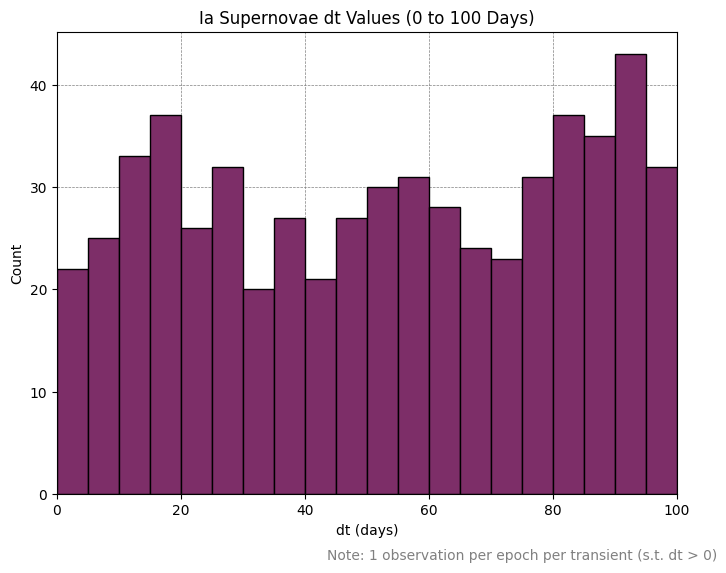

In [54]:
# Filter the data to include only dt values from 0 to 100 days
ia_after_df_zoom = ia_after_df[ia_after_df['dt'] <= 100]

# Define the bin edges with an even width of 5, focusing on the range from 0 to 100
bin_width = 5
bin_edges = np.arange(0, 100 + bin_width, bin_width)

# Plot the histogram for dt values from 0 to 100 days
plt.figure(figsize=(8, 6))

# Add grid with dashed lines
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=1)

# Create the histogram
plt.hist(ia_after_df_zoom['dt'], bins=bin_edges, color='#7D2E68', edgecolor='black', zorder=2)

# Set the x-axis limits to focus on the range from 0 to 100 days
plt.xlim(0, 100)

# Add labels and title
plt.title('Ia Supernovae dt Values (0 to 100 Days)')
plt.xlabel('dt (days)')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per epoch per transient (s.t. dt > 0)', 
            fontsize=10, color='gray', ha='right')


# Show the plot
plt.show()


### Ia Redshifts

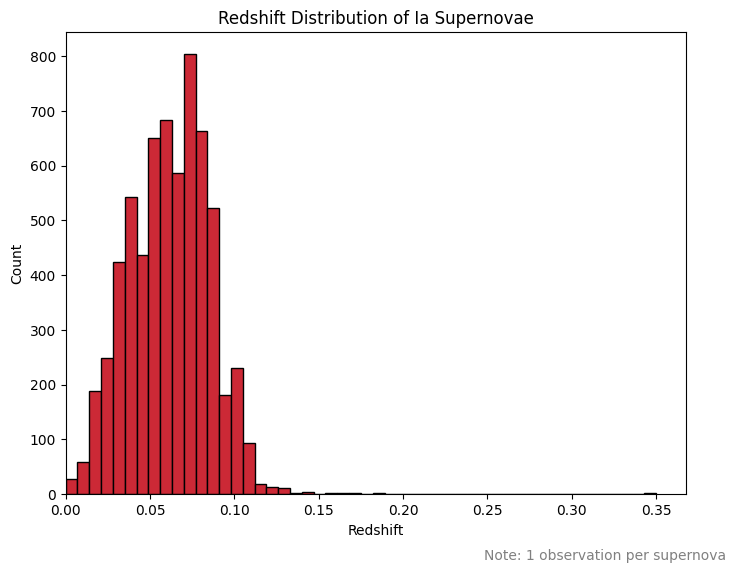

In [78]:
# Define the bin edges or let matplotlib choose automatically
bin_edges = 50  # Adjust the number of bins as needed

# Plot the histogram
plt.figure(figsize=(8, 6))

# Create the histogram with redshift values from ia_dataframe
plt.hist(ia_dataframe['redshift'], bins=bin_edges, color='#CC2936', edgecolor='black')

# Set the x-axis limits to start at 0.0
plt.xlim(left=0)

# Add labels and title
plt.title('Redshift Distribution of Ia Supernovae')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per supernova', 
            fontsize=10, color='gray', ha='right')

# Show the plot
plt.show()


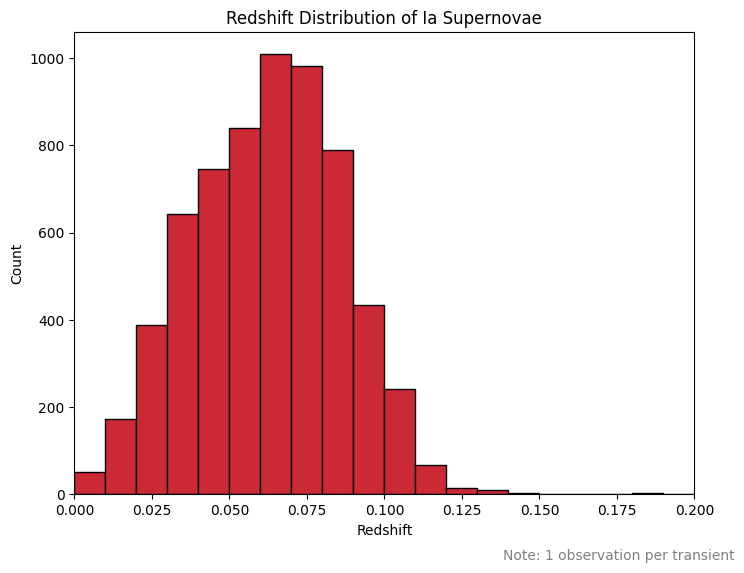

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges with a width of 0.01
bin_edges = np.arange(0, 0.21, 0.01)  # Adjust the right limit as needed

# Plot the histogram
plt.figure(figsize=(8, 6))

# Create the histogram with redshift values from ia_dataframe
plt.hist(ia_dataframe['redshift'], bins=bin_edges, color='#CC2936', edgecolor='black')

# Set the x-axis limits to start at 0.0 and go up to 0.2
plt.xlim(left=0, right=0.2)

# Add labels and title
plt.title('Redshift Distribution of Ia Supernovae')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per supernova', 
            fontsize=10, color='gray', ha='right')

# Show the plot
plt.show()



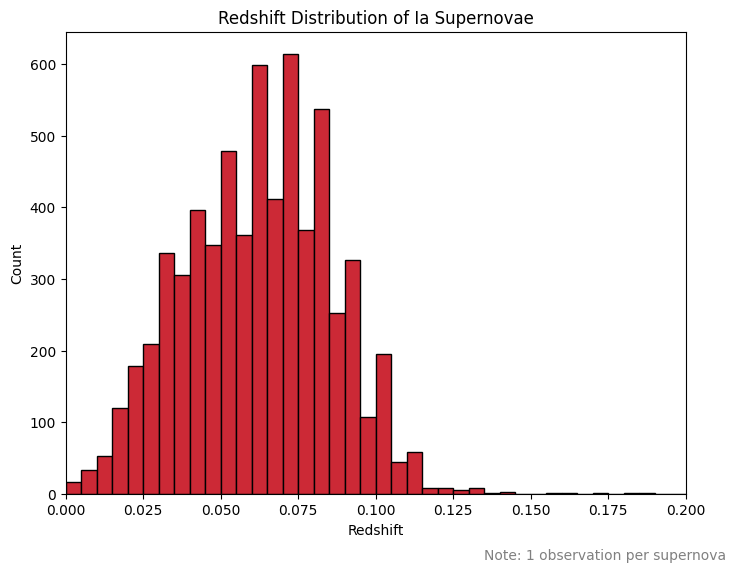

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges with a width of 0.01
bin_edges = np.arange(0, 0.21, 0.005)  # Adjust the right limit as needed

# Plot the histogram
plt.figure(figsize=(8, 6))

# Create the histogram with redshift values from ia_dataframe
plt.hist(ia_dataframe['redshift'], bins=bin_edges, color='#CC2936', edgecolor='black')

# Set the x-axis limits to start at 0.0 and go up to 0.2
plt.xlim(left=0, right=0.2)

# Add labels and title
plt.title('Redshift Distribution of Ia Supernovae')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per supernova', 
            fontsize=10, color='gray', ha='right')
# Show the plot
plt.show()



In [70]:
ia_dataframe[ia_dataframe['redshift'] > 0.2]

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,StartJD
4804,ZTF22aaylnhq,SN2022qmx,17:35:44.32,+04:49:56.8,1806.69,r,18.625,-22.80,>34.858,11.898,>22.96,SN Ia,0.35,19.028335,0.497,2.459793e+06


### RMS to Luminosity Histogram

In [5]:
from astropy.cosmology import Planck18

ia_luminosity_df = pd.DataFrame(pd.read_csv("final_ia_transients.csv"))

def add_luminosities(dataframe):
    """ 
    Given a pandas dataframe, will calculate the luminosities in erg/s/hz and
    append them to the dataframe as a new column
    """
    if 'Luminosity (erg/s/Hz)' in dataframe.columns:
        print("Column 'Luminosity (erg/s/Hz)' already exists. Please remove it or choose a different name.")
        return  # Exit the function if the column exists

    luminosities = []
    for n in range(len(dataframe['RMS Flux'])):
        rms = dataframe['RMS Flux'][n]
        redshift = dataframe['redshift'][n]
        rms_mjy = rms * u.mJy
        rms_jy = rms_mjy.to('Jy')
        rms_ergs_mpc2_s_hz = rms_jy.to(u.erg / (u.Mpc**2 * u.s * u.Hz))
        dist_mpc = Planck18.luminosity_distance(redshift)
        luminosity = 4 * np.pi * (dist_mpc**2) * rms_ergs_mpc2_s_hz
        luminosities.append(luminosity.value)

    dataframe['Luminosity (erg/s/Hz)'] = luminosities

add_luminosities(ia_luminosity_df)




Column 'Luminosity (erg/s/Hz)' already exists. Please remove it or choose a different name.


In [6]:
ia_luminosity_df

,Transient Name,Epoch,Peak Flux,RMS Flux,redshift,dt,Luminosity (erg/s/Hz)
0,ZTF17aabtvsy,VLASS1.2v2,0.458,0.135,0.06922,-1244.52,1.680712e+28
1,ZTF17aabtvsy,VLASS2.2,0.342,0.126,0.06922,-321.52,1.568664e+28
2,ZTF17aacldgo,VLASS1.1v2,0.313,0.122,0.07200,-1808.40,1.649641e+28
3,ZTF17aacldgo,VLASS2.1,0.321,0.155,0.07200,-788.40,2.095855e+28
4,ZTF17aacldgo,VLASS3.1,0.358,0.128,0.07200,182.60,1.730771e+28
...,...,...,...,...,...,...,...
16048,ZTF24aahmqzq,VLASS1.1v2,0.367,0.112,0.05931,-2265.42,1.009643e+28
16049,ZTF24aahmqzq,VLASS2.1,0.448,0.135,0.05931,-1287.42,1.216980e+28
16050,ZTF24aahmqzq,VLASS3.1,0.488,0.178,0.05931,-361.42,1.604611e+28
16051,ZTF24aahoihk,VLASS1.2v2,0.443,0.141,0.05000,-1804.19,8.915277e+27


In [7]:
def get_middle_value(group):
    """ Custom logic to return the middle value or average for each group """
    sorted_group = group.sort_values()
    group_len = len(sorted_group)
    
    if group_len == 1:  # If only one item, return that item
        return sorted_group.iloc[0]
    elif group_len == 2:  # If two items, return the average of the two
        return sorted_group.mean()
    else:  # If three or more, return the middle value (second largest)
        middle_index = group_len // 2
        return sorted_group.iloc[middle_index]

def get_luminosities_per_transient(dataframe):
    """
    Groups the dataframe by 'Transient Name' and returns one luminosity per transient
    based on the middle-value logic.
    """
    grouped = dataframe.groupby('Transient Name')['Luminosity (erg/s/Hz)']
    return grouped.apply(get_middle_value)

luminosity_per_transient = pd.DataFrame(get_luminosities_per_transient(ia_luminosity_df))

luminosity_per_transient


,Luminosity (erg/s/Hz)
Transient Name,
ZTF17aabtvsy,1.624688e+28
ZTF17aacldgo,1.730771e+28
ZTF17aadlxmv,1.117361e+28
ZTF18aaaonon,1.461914e+28
ZTF18aaaqexr,1.730984e+28
...,...
ZTF24aahkesn,1.655232e+28
ZTF24aahlvgk,2.042178e+28
ZTF24aahmgvr,2.930104e+27


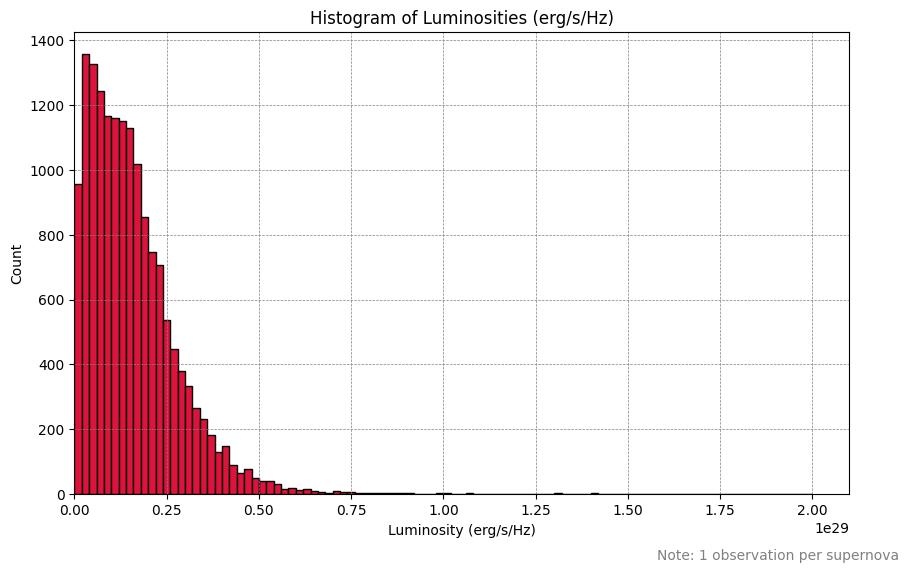

In [8]:
# Convert luminosity column back to float for histogram plotting
ia_luminosity_df['Luminosity (erg/s/Hz)'] = ia_luminosity_df['Luminosity (erg/s/Hz)'].apply(lambda x: float(x))


bin_width = 2e27
bins = np.arange(0, 2e29 + bin_width, bin_width)  # Adjust upper limit as needed

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(ia_luminosity_df['Luminosity (erg/s/Hz)'], bins=bins, color='crimson', edgecolor='black')


# Set x-axis limits to start at 0
plt.xlim(left=0)

# Add labels and title
plt.title('Histogram of Luminosities (erg/s/Hz)')
plt.xlabel('Luminosity (erg/s/Hz)')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per supernova', 
            fontsize=10, color='gray', ha='right')

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Show the plot
plt.show()


### Luminosity Plot

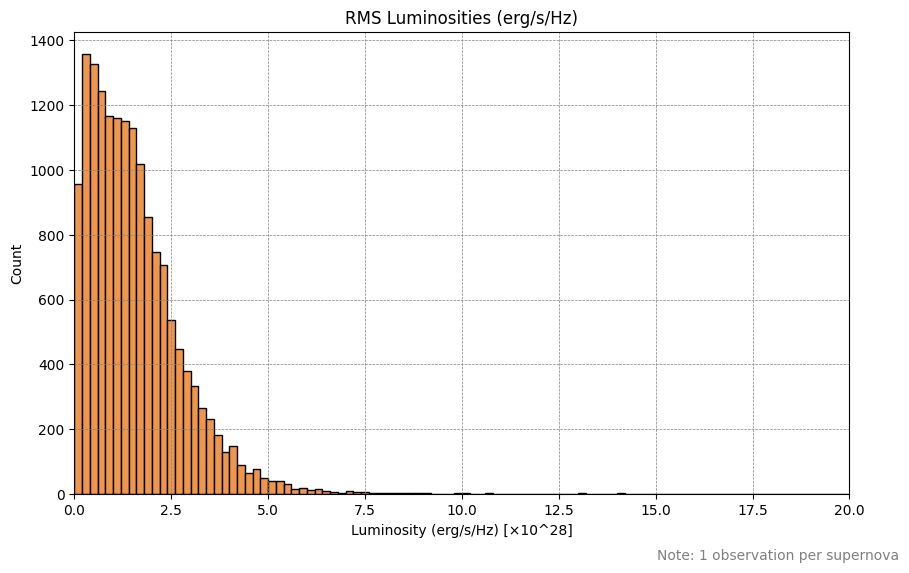

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Ensure you have the DataFrame ready with luminosities
# ia_luminosity_df = pd.read_csv('final_ia_luminosities.csv')  # Uncomment to load from CSV if needed

# Convert luminosity column back to float for histogram plotting
ia_luminosity_df['Luminosity (erg/s/Hz)'] = ia_luminosity_df['Luminosity (erg/s/Hz)'].apply(lambda x: float(x))

# Set the bin edges based on the desired width of 1e27
bin_width = 2e27
bins = np.arange(0, 2e29 + bin_width, bin_width)  # Adjust upper limit as needed

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(ia_luminosity_df['Luminosity (erg/s/Hz)'], bins=bins, color='#EE964B', edgecolor='black')

# Set x-axis limits to start at 0 and go up to 2e29
plt.xlim(0, 2e29)

# Format x-axis to display in e28
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 1e-28:.1f}'))

# Add labels and title
plt.title('RMS Luminosities (erg/s/Hz)')
plt.xlabel('Luminosity (erg/s/Hz) [×10^28]')
plt.ylabel('Count')
plt.figtext(0.95, 0, 'Note: 1 observation per supernova', 
            fontsize=10, color='gray', ha='right')

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Show the plot
plt.show()




### Log Scale RMS Luminosity Plot

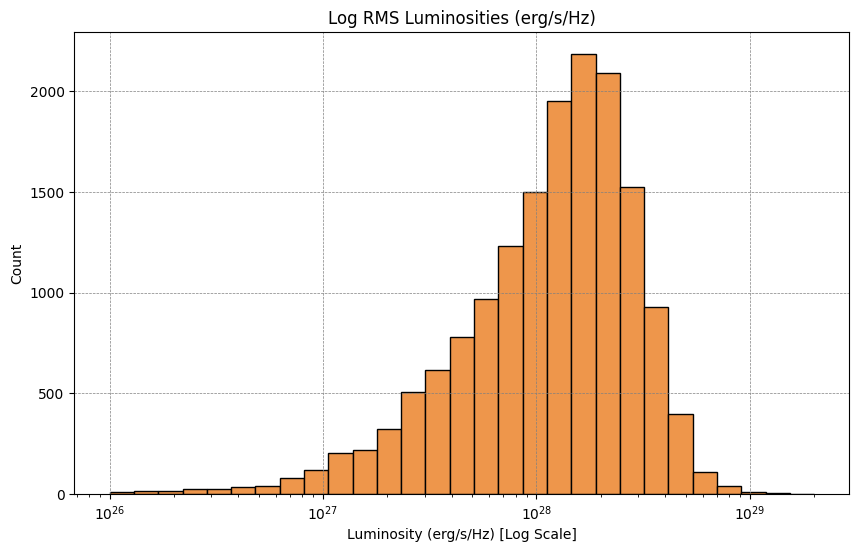

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Ensure you have the DataFrame ready with luminosities
# ia_luminosity_df = pd.read_csv('final_ia_luminosities.csv')  # Uncomment to load from CSV if needed

# Convert luminosity column back to float for histogram plotting
ia_luminosity_df['Luminosity (erg/s/Hz)'] = ia_luminosity_df['Luminosity (erg/s/Hz)'].apply(lambda x: float(x))

# Set the bins using logarithmic spacing
bins = np.logspace(np.log10(1e26), np.log10(2e29), num=30)  # Adjust these limits as needed

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(ia_luminosity_df['Luminosity (erg/s/Hz)'], bins=bins, color='#EE964B', edgecolor='black')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels and title
plt.title('Log RMS Luminosities (erg/s/Hz)')
plt.xlabel('Luminosity (erg/s/Hz) [Log Scale]')
plt.ylabel('Count')

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Show the plot
plt.show()


In [17]:
import importlib
importlib.reload(vlass_search)

File downloaded to: VLASS_dyn_summary.php


<module 'vlass_search' from 'd:\\summer_research_code\\Query_VLASS_2\\vlass_search.py'>